# 1 导入库

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 2 主要函数

In [2]:
def yolo_head(features, anchors, num_classes, input_shape, calc_loss=False):
    num_anchors = len(anchors)

    anchors_tensor = tf.reshape(tf.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = features.shape[1:3]

    grid_y = tf.tile(tf.reshape(
        tf.keras.backend.arange(0, stop=grid_shape[0]),
        [-1, 1, 1, 1]), [1, grid_shape[1], 1, 1])
    grid_x = tf.tile(tf.reshape(
        tf.keras.backend.arange(0, stop=grid_shape[1]),
        [1, -1, 1, 1]), [grid_shape[0], 1, 1, 1])
    grid = tf.keras.layers.concatenate([grid_x, grid_y])
    grid = tf.cast(grid, features.dtype)
    # batch_size
    features = tf.reshape(features, [1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    box_xy = (tf.sigmoid(features[..., :2]) + grid) / tf.cast(grid_shape[::-1], features.dtype)
    box_wh = tf.exp(features[..., 2:4]) * tf.cast(anchors_tensor, features.dtype) / tf.cast(input_shape[::-1],
                                                                                            features.dtype)
    box_confidence = tf.sigmoid(features[..., 4:5])
    box_class_probs = tf.sigmoid(features[..., 5:])

    if calc_loss == True:
        return grid, features, box_xy, box_wh

    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = tf.cast(input_shape, box_yx.dtype)
    image_shape = tf.cast(image_shape, box_yx.dtype)
    new_shape = tf.round(image_shape * tf.keras.backend.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = tf.keras.backend.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= tf.keras.backend.concatenate([image_shape, image_shape])
    return boxes
def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats, anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = tf.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = tf.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores

In [3]:
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)
anchors = get_anchors('D:/PycharmProjects/YOLOv3/data/yolo_anchors.txt')
anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

# 3 前向推理

## 3.1 读取图片

In [47]:
img = cv2.resize(cv2.imread('timg.jpg', 1), (416, 416)) / 255.0
img = np.expand_dims(img, 0)

## 3.2 载入训练好的模型

In [5]:
model = tf.keras.models.load_model('D:/PycharmProjects/YOLOv3/yolov3.h5')

## 3.3 模型预测

In [48]:
features = model.predict(img)
for i in range(3):
    print(features[i].shape)
# 分别将原图降采样32倍、16倍、8倍

(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


## 3.3 对网络输出的feature进行处理，得到候选boxes

In [49]:
box_xy, box_wh, box_confidence, box_class_probs = yolo_head(features[0], anchors[anchor_mask[0]], 80, [416, 416])
print('box_xy.shape={}, box_wh.shape={}'.format(box_xy.shape, box_wh.shape))
print('box_confidence.shape={}'.format(box_confidence.shape))
print('box_class_probs.shape={}'.format(box_class_probs.shape))

box_xy.shape=(1, 13, 13, 3, 2), box_wh.shape=(1, 13, 13, 3, 2)
box_confidence.shape=(1, 13, 13, 3, 1)
box_class_probs.shape=(1, 13, 13, 3, 80)


## 3.4 对上一步的boxes进行放缩等处理，以适配原图大小

In [50]:
boxes = yolo_correct_boxes(box_xy, box_wh, input_shape=[416, 416], image_shape=[416, 416])

In [51]:
print('boxes.shape={}'.format(boxes.shape))

boxes.shape=(1, 13, 13, 3, 4)


## 3.5 对处理好的boxes进行reshape，得到所有的box及其对应的分类概率

In [52]:
boxes = tf.reshape(boxes, [-1, 4])
box_scores = box_confidence * box_class_probs
box_scores = tf.reshape(box_scores, [-1, 80])
print('boxes.shape={}'.format(boxes.shape))
print('box_scores.shape={}'.format(box_scores.shape))

boxes.shape=(507, 4)
box_scores.shape=(507, 80)


## 3.6 重复3.3~3.5，得到3个feature对应的结果

In [53]:
boxes = []
box_scores = []
for l in range(3):
    _boxes, _box_scores = yolo_boxes_and_scores(features[l],
                                                anchors[anchor_mask[l]], 80, [416, 416], [416, 416])
    boxes.append(_boxes)
    box_scores.append(_box_scores)
boxes = tf.keras.backend.concatenate(boxes, axis=0)
box_scores = tf.keras.backend.concatenate(box_scores, axis=0)

In [54]:
print((13*13 + 26*26 + 52*52) * 3)
boxes.shape

10647


TensorShape([10647, 4])

## 3.7 设定iou等值，对候选的box进行筛选

In [55]:
max_boxes = 20
score_threshold = .6
iou_threshold = .5

In [76]:
mask = box_scores >= score_threshold
max_boxes_tensor = tf.keras.backend.constant(max_boxes, dtype='int32')
boxes_ = []
scores_ = []
classes_ = []
for c in range(1):
    class_boxes = tf.boolean_mask(boxes, mask[:, c])# 得到得分高于阈值的box
    print('class_boxes={}'.format(class_boxes))
    class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
    print('class_box_scores={}'.format(class_box_scores))
    nms_index = tf.image.non_max_suppression(
        class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
    print('nms_index={}'.format(nms_index))
    class_boxes = tf.keras.backend.gather(class_boxes, nms_index)
    class_box_scores = tf.keras.backend.gather(class_box_scores, nms_index)
    classes = tf.keras.backend.ones_like(class_box_scores, 'int32') * c
    print('classes={}'.format(classes))
    boxes_.append(class_boxes)
    scores_.append(class_box_scores)
    classes_.append(classes)
boxes_ = tf.keras.backend.concatenate(boxes_, axis=0)
scores_ = tf.keras.backend.concatenate(scores_, axis=0)
classes_ = tf.keras.backend.concatenate(classes_, axis=0)

class_boxes=[[ 56.456276  72.86099  379.32663  173.15477 ]
 [ 58.173294  77.88431  374.41953  181.85956 ]
 [ 39.518288 260.89935  393.658    372.69617 ]
 [ 35.284153 262.83508  398.0043   386.02393 ]
 [ 61.116127  73.83381  390.32755  170.542   ]
 [ 68.117294  78.11073  384.28806  181.98584 ]
 [ 52.646904 261.99063  401.07928  369.78476 ]
 [ 53.16426  264.9104   400.01636  382.21494 ]]
class_box_scores=[0.9987786  0.99054706 0.9683957  0.99481285 0.98789525 0.7797014
 0.8295884  0.9399097 ]
nms_index=[0 3]
classes=[0 0]


In [75]:
boxes_

<tf.Tensor: id=19925, shape=(2, 4), dtype=float32, numpy=
array([[ 56.456276,  72.86099 , 379.32663 , 173.15477 ],
       [ 35.284153, 262.83508 , 398.0043  , 386.02393 ]], dtype=float32)>

In [58]:
scores_

<tf.Tensor: id=12904, shape=(2,), dtype=float32, numpy=array([0.9987786 , 0.99481285], dtype=float32)>

In [59]:
classes_

<tf.Tensor: id=12909, shape=(2,), dtype=int32, numpy=array([0, 0])>

## 3.8 将框画在原图上

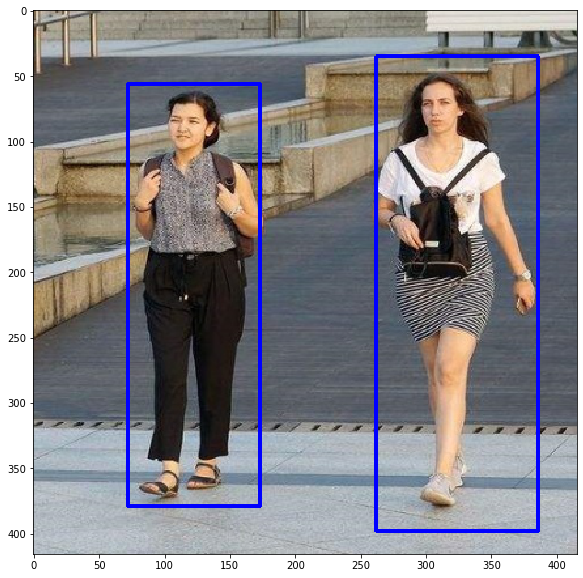

In [73]:
img = cv2.resize(cv2.imread('timg.jpg', 1), (416, 416))
for i in range(boxes_.shape[0]):
    result = cv2.rectangle(img, (boxes_[i][1],boxes_[i][0]), (boxes_[i][3],boxes_[i][2]), (255,0,0), 2)

result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.show()